In [1]:
from Basic_Model import *
from Newton import *

In [6]:
def add_arrow(line, position=None, direction='right', size=15, color=None,type = 0):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()
    
    if position is None:
        if type == 0:
            position = xdata.mean()
        else : position = ydata.mean()
    # find closest index
    if type == 0:
        start_ind = np.argmin(np.absolute(xdata - position))
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1
    else : 
        start_ind = np.argmin(np.absolute(ydata - position))
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1
    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

def Simulation_Reach(w1,w2,w3,w4,r1,r2,xinit,xend,Time):
    Num_iter = int(Time*1000)
    dt = 0.001
    st1,st2 = newton(f,df,1e-8,1000,xinit[0],xinit[1])
    obj1,obj2 = newton(f,df,1e-8,1000,xend[0],xend[1])
    x0 = np.array([st1,0,0,st2,0,0,obj1,0,0,obj2,0,0])
    xnonlin0 = np.concatenate((x0[:7],np.array([x0[9]])))
    Bruit = True
    NbreVar = 8
    
    #Define Weight Matrices
    Rnonlin = np.array([[r1,0],[0,r2]])
    Qnonlin = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  
    Az = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    Bz = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])

    S = Qnonlin
    array_L = np.zeros((Num_iter-1,2,NbreVar))    
    for k in range(Num_iter-1):
        L = np.linalg.inv(Rnonlin+Bz.T@S@Bz)@Bz.T@S@Az
        array_L[Num_iter-2-k] = L
        S = Az.T@S@(Az-Bz@L)
    

    H,L,x0,A,B = np.identity(8),array_L,xnonlin0,Az,Bz
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2))
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    array_reelx[0] = np.array([x0[0],x0[3],x0[1],x0[4],xinit[0],xinit[1]])
    xhat = x0
    x = x0
    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx
    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat
    for k in range(Num_iter-1):
        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar)
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat - B@L[k].reshape(np.flip(B.shape))@xhat + K@(y[k]-H@xhat)
        x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        v = -L[k].reshape(np.flip(B.shape))@xhat
            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C))
            
        M = np.array([[a1+2*a2*cos(reelx[1]),a3+a2*cos(reelx[1])],[a3+a2*cos(reelx[1]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*reelx[1])*reelx[3]/(Denominator*Denominator),
                             (a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)],
                            [(a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator),
                            (-2*a2*sin(reelx[1])*reelx[3]*Denominator+(2*a2*cos(reelx[1])+a1)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
    
        u = 1/K*M@v-1/K*M@Minvdot@M@np.array([x[2],x[5]])+M@np.array([x[2],x[5]])+C+Bdyn@np.array([x[1],x[4]])+1/K*Cdot+1/K*Bdyn@np.array([x[2],x[5]])
        new_reelx[4:6] += dt*K*(u-reelx[4:6])
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx    

#Plot
    x0 = x0
    reelx = array_reelx.T[:,:][:,::1]
    plotted = plt.plot(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = "blue")[0]
    add_arrow(plotted,0)
    reelx = [obj1,obj2]
    plt.scatter(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30)
    reelx = [st1,st2]
    plt.scatter(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = "green")
    plt.xlabel("x [cm]")
    plt.ylabel("y [cm]")
    plt.grid()
    plt.axis("equal")
    
    plt.show()
    reelx = array_reelx.T[:,:][:,::1]
    plt.plot(np.linspace(0,dt*Num_iter,Num_iter),reelx[2],label = "Shoulder Velocity")
    plt.plot(np.linspace(0,dt*Num_iter,Num_iter),reelx[3],label = "Elbow Velocity")
    plt.xlabel("Time [sec]")
    plt.ylabel("Angular Velocity [rad/sec]")
    plt.legend()
    plt.grid()
    plt.show()
    
    

    #axis = plt.gca()
    #axis.set_aspect('equal', adjustable='box')
    
    

    

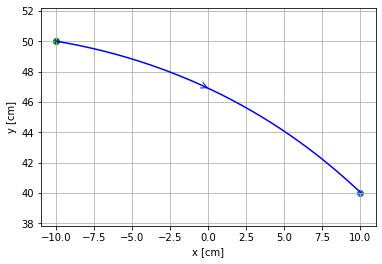

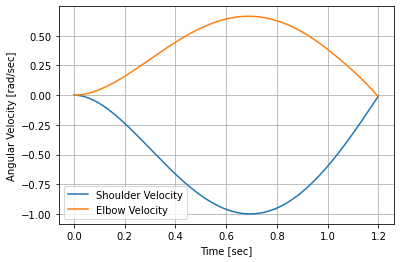

In [7]:
#Ref 0 45

Xstart = np.array([-10,50])
Xend = np.array([10,40])
Simulation_Reach(100000,1000,100000,1000,0.0001,0.00001,Xstart,Xend,1.2)

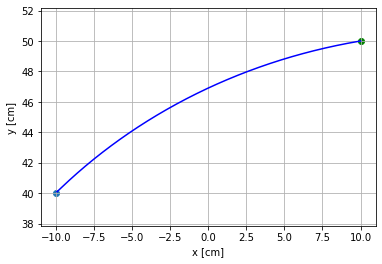

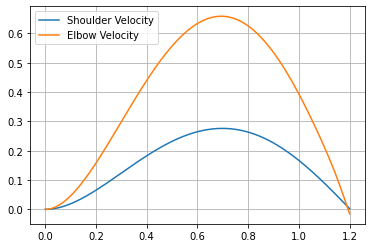

In [135]:
Xstart = np.array([10,50])
Xend = np.array([-10,40])
Simulation_Reach(100000,1000,100000,1000,0.0001,0.00001,Xstart,Xend,1.2)